# Toggl Revamp V0 data management

In [212]:
import logging
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import csv
import requests
import datetime as dt
from base64 import b64encode
from zoneinfo import ZoneInfo 
import json
import unicodedata
import os
from supabase import create_client, Client

import pytz

import logging
from typing import Optional, Any

import pandas as pd
import datetime as dt
import unicodedata


import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional


from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
from data_management import *

In [214]:
class test:
    def __init__(self):
        self._configure_auth()
        
    @staticmethod
    def _load_config(file_path):
        """Load the configuration file"""
        
        with open(file_path, 'r') as file:
            return json.load(file)

    def _configure_auth(self):
        """set auth stuff"""
        
        conf = self._load_config("config.json")
        self.sb_url, self.sb_key = conf['supabase']['project_key'], conf['supabase']['api_key']
        self.tog_email, self.tog_pw = conf['toggl']['email'], conf['toggl']['password']
        self.toggl_headers = {
            'content-type': 'application/json', 
            'Authorization': 'Basic %s' %  b64encode(
                f"{self.tog_email}:{self.tog_pw}".encode('utf-8')
            ).decode("ascii")
        }
        return
t = test()
config = t._load_config(
    "location_of_config"


In [215]:
class TogglManager:
    def __init__(self, headers):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.debug("Toggl Manager log initialised")
        self.workspace_id = None
        self.headers = headers
        self.project_metadata = None
        self.client_metadata = None

    def _get_timer_data(self):
        """
        send request
        return timers from 90 days prior to date of run
        """
        
        self.logger.info("Requesting toggl timer data")
        params = {
            "start_date" : (dt.datetime.today() - dt.timedelta(days=90)).strftime("%Y-%m-%d"),
            "end_date" :  (dt.datetime.today()  + dt.timedelta(days=1)).strftime("%Y-%m-%d")
        }
        
        try:
            response = requests.get(
                'https://api.track.toggl.com/api/v9/me/time_entries', headers=self.headers, params=params
            )
            response.raise_for_status()
        except Exception as e:
            self.logger.error("Failed to pull data", exc_info=True)
            return None
            
        try:
            data = response.json()
            self.workspace_id = data[0]['workspace_id']
            self.logger.info(f"Successfully grabbed timer data.\nWorkspace_id: {self.workspace_id}")
            return data
        except ValueError as e:
            self.logger.error("Failed to parse JSON response", exc_info=True)
            return None

    def _get_current_timer(self):
        self.logger.info("Requesting current timer data")

        try:
            response = requests.get(
                'https://api.track.toggl.com/api/v9/me/time_entries/current', headers=self.headers
            )
            response.raise_for_status()
        
        except Exception as e:
            self.logger.error("Failed to pull current timer", exc_info=True)
            return None

        try:
            return response.json()
        except ValueError as e:
            self.logger.error("Failed to parse current JSON response", exc_info=True)
            return None

    def _get_metadata(self, target):
        """
        send request
        return project or client data
        """
        
        self.logger.info(f"Requesting {target} metadata")
        
        assert target in ['projects', 'clients']
        
        if target == "projects" and self.project_metadata != None:
            self.logger.info("Re-reading existing project metadata")
            return self.project_metadata
        if target == "clients" and self.client_metadata != None:
            self.logger.info("Re-reading existing client metadata")
            return self.client_metadata
            
        try:
            response = requests.get(
            'https://api.track.toggl.com/api/v9/workspaces/{}/{}'.format(self.workspace_id, target), headers=self.headers)
            response.raise_for_status()
        except Exception as e:
            self.logger.error(f"Failed to pull {target} data", exc_info=True)
            return None
        try:
            data = response.json()
            self.logger.info("Successfully grabbed {} metadata".format(target))
            if target == "projects":
                self.project_metadata = data
            else:
                self.client_metadata = data
            self.logger.info("Successfully grabbed {} metadata".format(target))
            
            return data
        except ValueError:
            self.logger.error("Failed to parse JSON response", exc_info=True)
            return None

    def map_clients_to_timers(self, timer_data):
        try:
            client_metadata = self._get_metadata("clients")
            cli_map = {
                str(c['id']) : {
                    "client_name" : c['name'],
                    "client_archived": c['archived']
                } for c in client_metadata
            }
            
            self.logger.info("Applying client metadata to timers")
            if isinstance(timer_data, list):
                for timer in timer_data:
                    if timer['project_client'] == None:
                        timer['client_name'] = None
                        timer['client_archived'] = None
                    else:
                        cli = str(timer['project_client'])
                        timer['client_name'] = cli_map[cli]['client_name']
                        timer['client_archived'] = cli_map[cli]['client_archived']
            else:
                if timer_data['project_client'] == None:
                    timer_data['client_name'] = None
                    timer_data['client_archived'] = None
                else:
                    cli = str(timer_data['project_client'])
                    timer_data['client_name'] = cli_map[cli]['client_name']
                    timer_data['client_archived'] = cli_map[cli]['client_archived']
            return timer_data
            
        except Exception as e:
            self.logger.error("Failed to read cli map", exc_info=True)
            return None

    
    def map_projects_to_timers(self, timer_data):
        try:
            project_metadata = self._get_metadata("projects")
            pid_map = {
                str(p['id']) : {
                    "project_name" : p['name'],
                    "project_colour" : p['color'],
                    "project_status": p['status'],
                    "project_client" : p['client_id']
                } for p in project_metadata
            }

            self.logger.info("Applying project metadata to timers")
            if isinstance(timer_data, list):
                for timer in timer_data:
                    if timer['project_id'] == None:
                        timer['project_name'] = None
                        timer['project_colour'] = None
                        timer['project_status'] = None
                        timer['project_client'] = None
                    else:
                        pid = str(timer['project_id'])
                        timer.update(pid_map[pid])
            else:
                if timer_data['project_id'] == None:
                    timer_data['project_name'] = None
                    timer_data['project_colour'] = None
                    timer_data['project_status'] = None
                    timer_data['project_client'] = None
                else:
                    pid = str(timer_data['project_id'])
                    timer_data.update(pid_map[pid])
            return timer_data
            
        except Exception as e:
            self.logger.error("Failed to read pid map", exc_info=True)
            return None

    def get_mapped_timer_data(self, start_date=None, end_date=None):
        """
        Orchestrates complete timer data collection and mapping process
        
        Args:
            start_date (datetime): Optional start of range
            end_date (datetime): Optional end of range
        """
        self.logger.info("Starting timer data collection and mapping")
        
        # Get base timer data
        timer_data = self._get_timer_data()
        if timer_data is None:
            self.logger.error("Failed to get timer data")
            return None
        
        # Map project data
        timer_data = self.map_projects_to_timers(timer_data)
        if timer_data is None:
            self.logger.error("Failed to map project data")
            return None
            
        # Map client data
        timer_data = self.map_clients_to_timers(timer_data)
        if timer_data is None:
            self.logger.error("Failed to map client data")
            return None
        
        self.logger.info("Successfully collected and mapped timer data")
        return timer_data

    def get_mapped_current_timer(self):
        """
        Fetches the current running timer and applies project and client metadata to make it homogeneous
        with historical timer data.
    
        Returns:
            dict: The current timer with mapped metadata, or None if no timer is running or an error occurs.
        """
        self.logger.info("Starting current timer data collection and mapping")

        assert self.workspace_id != None
        
        # Fetch the current timer
        current_timer = self._get_current_timer()
        if current_timer is None:
            self.logger.info("No current timer running or failed to fetch current timer")
            return None
    
        # If the API returns null (no running timer), return None
        if not current_timer:  # Toggl API returns null if no timer is running
            self.logger.info("No current timer running")
            return None
    
        # Map project data
        current_timer = self.map_projects_to_timers(current_timer)
        if current_timer is None:
            self.logger.error("Failed to map project data to current timer")
            return None
    
        # Map client data
        current_timer = self.map_clients_to_timers(current_timer)
        if current_timer is None:
            self.logger.error("Failed to map client data to current timer")
            return None
    
        self.logger.info("Successfully collected and mapped current timer data")
        return current_timer

In [216]:
def modify_current_timer_for_upsert(raw_data: list[dict]) -> list[dict]:
    """
    Modify running timer in raw Toggl data to match historical pattern for Supabase upsert.
    - Assigns implicit stop time to running timers (rounded to whole seconds)
    - Calculates duration as positive seconds (float64)
    - Leaves all other fields unchanged
    - Returns data in original list-of-JSONs format for Supabase
    """
    # Convert to DataFrame for processing
    processed = pd.DataFrame(raw_data)
    
    # --- Convert start and stop to datetime (UTC)
    processed['start'] = pd.to_datetime(processed['start'], utc=True)
    processed['stop'] = pd.to_datetime(processed['stop'], utc=True)
    
    # --- Convert duration to float64 to avoid type mismatch
    processed['duration'] = processed['duration'].astype('float64')
    
    # --- Handle running timers
    now_utc = pd.Timestamp.now(tz='UTC').round('s')  # Round to nearest second
    is_running = processed['stop'].isna() & (processed['duration'] < 0)
    processed.loc[is_running, 'stop'] = now_utc
    processed.loc[is_running, 'duration'] = (now_utc - processed.loc[is_running, 'start']).dt.total_seconds()
    
    # --- Convert stop back to ISO strings (or None)
    processed['stop'] = processed['stop'].apply(lambda x: x.isoformat() if pd.notna(x) else None)
    processed['start'] = processed['start'].apply(lambda x: x.isoformat() if pd.notna(x) else None)
    
    return processed.to_dict(orient='records')

In [217]:
class SupabaseManager:
    def __init__(self, client):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.debug("SupabaseWriter logging initialized")
        self.cli = client

    def _sb_write(self, data: Any, table_name: str, on_conflict: str = "id") -> Optional[Any]:
        """
        Push data to Supabase using upsert for handling conflicts.

        Args:
            data: Data to push (list of dicts or single dict)
            table_name (str): Name of the Supabase table
            on_conflict (str): Column name to handle upsert conflicts (default: "id")

        Returns:
            Optional[Any]: Response from Supabase or None if failed
        """
        self.logger.info(f"Writing data to {table_name}")
        if data is not None and data != {}:
            try:
                # Ensure data is in a list format for upsert
                if not isinstance(data, list):
                    data = [data]
                
                response = self.cli.table(table_name).upsert(data, on_conflict=on_conflict).execute()
                self.logger.info(f"Successfully pushed data to {table_name}")
                return response
            except Exception as e:
                self.logger.error(f"Failed to push data to {table_name}", exc_info=True)
                return None
        else:
            self.logger.warning(f"No data to push to {table_name}")
            return None

    def _sb_read(self, table_name: str) -> Optional[list]:
        """
        Read data from a Supabase table.

        Args:
            table_name (str): Name of the Supabase table

        Returns:
            Optional[list]: List of data from the table or None if failed
        """
        self.logger.info(f"Reading {table_name} from SB")
        try:
            response = self.cli.table(table_name).select("*").execute()
            self.logger.info(f"Successfully read {table_name} from SB")
            data = response.data
            return data
        except Exception as e:
            self.logger.error(f"Failed to read {table_name} from SB", exc_info=True)
            return None
            
# sm = SupabaseManager(sb_cli)
# write_result = sm._sb_write(modified_df, "time_entries")



In [219]:
def preprocess_toggl_data_for_analysis(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocess Toggl data for metrics calculation.
    - Extracts date from start timestamp
    - Handles timezone conversion from UTC to Australia/Sydney
    - Creates necessary date columns
    - Splits into historical and today DataFrames
    """
    processed = df.copy()

    # --- Ensure all tags are string
    processed['tags'].astype('str')

    # --- Convert start and stop to datetime (UTC)
    processed['start_utc'] = pd.to_datetime(processed['start'], utc=True)
    processed['stop_utc'] = pd.to_datetime(processed['stop'], utc=True)
    processed['date_utc'] = processed['start_utc'].dt.date

    # --- Convert to Sydney timezone
    sydney_tz = pytz.timezone('Australia/Sydney')
    processed['start'] = processed['start_utc'].dt.tz_convert(sydney_tz)
    processed['stop'] = processed['stop_utc'].dt.tz_convert(sydney_tz)
    processed['date'] = processed['start'].dt.date

    # --- Ensure duration is numeric (seconds)
    def parse_duration(d):
        if isinstance(d, str) and ':' in d:
            # Handle HH:MM:SS format
            h, m, s = map(float, d.split(':'))
            return h * 3600 + m * 60 + s
        try:
            # Try converting to float (handles strings like '2011.0')
            return float(d)
        except (ValueError, TypeError):
            return 0.0  # Fallback for invalid values

    processed['duration'] = processed['duration'].apply(parse_duration)

    # --- Exclusions
    project_exclusions = ["Slept in", "Stayed-up", "Baseline"]
    processed = processed[~processed['project_name'].isin(project_exclusions)]
    processed = processed[~processed['tags'].str[0].str.contains("Ambling", na=False)]
        
    # --- Exclude archived projects and clients
    processed = processed[(processed['project_status'] == "active")]
    processed = processed[(processed['client_archived'] != "False")]

    # --- Split data from emojis
    def split_tag(tag):
        if not tag or pd.isna(tag):
            return {'tag': 'unknown', 'tag_emoji': '❓'}
        result = []
        for t in tag:
            if isinstance(t, str) and t:
                emoji = t[0]
                label = t[1:].strip().lower() if len(t) > 1 else 'unknown'
                label = unicodedata.normalize('NFKD', label).encode('ASCII', 'ignore').decode('ASCII').strip()
                result.append({'tag': label.strip(), 'tag_emoji': emoji})
        return result[0] if result else {'tag': 'unknown', 'tag_emoji': '❓'}

    tag_cols = processed['tags'].apply(split_tag)
    processed['tag'] = tag_cols.apply(lambda x: x['tag'])
    processed['tag_emoji'] = tag_cols.apply(lambda x: x['tag_emoji'])
    processed = processed.drop(columns=['tags'])

    # --- Split clients from emoji
    def split_client(client):
        if not client or pd.isna(client):
            return {'client': 'unknown', 'client_emoji': '❓'}
        emoji = client[0]
        label = client[1:].strip().lower() if len(client) > 1 else 'unknown'
        return {'client': label, 'client_emoji': emoji}

    processed['client'] = processed['client_name'].apply(lambda x: split_client(x)['client'])
    processed['client_emoji'] = processed['client_name'].apply(lambda x: split_client(x)['client_emoji'])
    processed = processed.drop(columns=['client_name'])

    # --- Split df into 2: historical, today
    # today_utc_date = dt.datetime.now(dt.timezone.utc).date()
    # historical_timers = processed.loc[processed['date'] < today_utc_date]
    # today_timers = processed.loc[processed['date'] == today_utc_date]

    today_sydney_date = dt.datetime.now(sydney_tz).date()
    historical_timers = processed.loc[processed['date'] < today_sydney_date]
    today_timers = processed.loc[processed['date'] >= today_sydney_date]
    
    return historical_timers, today_timers


#preprocess_toggl_data_for_analysis(pd.DataFrame(result))
    
# --- Testing for finished timers
# pd.DataFrame(result[:2]).info()
# test_hist, test_today = preprocess_toggl_data_for_analysis(pd.DataFrame(result))
# display(h.sort_values("start").tail())
# display(test_today.sort_values("start").tail())


# --- Testing for current timer
# display(current)

# _, ct = preprocess_toggl_data_for_analysis(pd.DataFrame(current))
# ct

# Metrics


In [220]:
def get_daily_series(df: pd.DataFrame, groupby_col: str, window_len: int = 8, context: str = "local", exclusions: dict = None) -> pd.DataFrame:
    """
    Get daily time series for specified grouping and context, with optional exclusions.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        groupby_col (str): Column to group by ('tag', 'project_name', 'client_name')
        window_len (int): Window length for filtering (in days)
        context (str): Either "local" (uses window_len) or "historical" (uses full dataset)
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude

    Returns:
        pd.DataFrame: Pivoted daily time series, filled with 0s for missing values
    """
    # Filter by window if context is "local"
    if context == "local":
        latest_date = df['date'].max()
        cutoff_date = latest_date - pd.Timedelta(days=window_len)
        df = df[df['date'] > cutoff_date]

    # Apply exclusions if provided
    if exclusions:
        if isinstance(exclusions, dict):
            if 'tag' in exclusions and groupby_col == 'tag':
                exclude_tags = exclusions['tag'] if isinstance(exclusions['tag'], list) else [exclusions['tag']]
                df = df[~df['tag'].str.lower().isin([t.lower() for t in exclude_tags])]
            if 'projects' in exclusions and groupby_col == 'project_name':
                exclude_projects = exclusions['projects'] if isinstance(exclusions['projects'], list) else [exclusions['projects']]
                df = df[~df['project_name'].isin(exclude_projects)]
            if 'clients' in exclusions and groupby_col == 'client_name':
                exclude_clients = exclusions['clients'] if isinstance(exclusions['clients'], list) else [exclusions['clients']]
                df = df[~df['client_name'].isin(exclude_clients)]
        else:
            raise ValueError("Exclusions must be a dictionary with keys 'tag', 'projects', or 'clients'")

    # Group by the specified column without exploding since 'tag' is a single value
    if groupby_col == 'tag':
        daily = df.groupby(['date', 'tag'])['duration'].sum()
    elif groupby_col in ['project_name', 'client_name']:
        daily = df.groupby(['date', groupby_col])['duration'].sum()
    else:
        raise ValueError(f"Unsupported groupby_col: {groupby_col}")

    return daily.reset_index().pivot(
        index='date',
        columns=groupby_col,
        values='duration'
    ).fillna(0)

def calculate_daily_total_work(df: pd.DataFrame) -> pd.Series:
    """
    Calculate the sum of all worked hours.
    - Exclude 'training' tag (case-insensitive)
    - Fill missing dates with 0
    """
    daily_tags = df.groupby(['date', 'tag'])['duration'].sum().reset_index()
    tag_matrix = daily_tags.pivot(
        index='date',
        columns='tag',
        values='duration'
    ).fillna(0)

    # Exclude 'training' tag, case-insensitive
    cols = [col for col in tag_matrix.columns if col.lower() != 'training']
    df_no_training = tag_matrix[cols]
    daily_sum = df_no_training.sum(axis=1)

    # Create complete date range
    date_range = pd.date_range(
        start=daily_sum.index.min(),
        end=daily_sum.index.max(),
        freq='D'
    )

    # Reindex with 0s for missing dates
    daily_sum = daily_sum.reindex(date_range, fill_value=0)
    return daily_sum

# def calculate_heat(df: pd.DataFrame, norm_window: int = 16, display_last: int = 12) -> pd.Series:
#     """Calculate system heat using adaptive normalization
    # old  version that just compiles all available data"""
#     series = calculate_daily_total_work(df)
#     intensity = series.rolling(window=3, min_periods=1).mean()
#     work_mask = intensity > 0
#     rolling_mean = intensity[work_mask].rolling(window=norm_window, min_periods=3).mean()
#     rolling_std = intensity[work_mask].rolling(window=norm_window, min_periods=3).std()
#     heat = ((intensity - rolling_mean) / rolling_std).fillna(0)
#     return heat[len(heat) - display_last:]

def calculate_heat(historical_df: pd.DataFrame, today_df: pd.DataFrame, norm_window: int = 16, display_last: int = 13) -> tuple[pd.Series, float]:
    """
    Calculate system heat using adaptive normalization.
    - Computes historical heat (13 days prior to today)
    - Computes today's heat separately

    Args:
        historical_df (pd.DataFrame): Preprocessed Toggl data (historical only)
        today_df (pd.DataFrame): Preprocessed Toggl data (today only)
        norm_window (int): Normalization window for rolling mean/std (default: 16)
        display_last (int): Number of historical days to display (default: 13)

    Returns:
        tuple: (historical_heat: pd.Series, today_heat: float)
    """
    # Calculate historical daily totals (excluding today)
    series = calculate_daily_total_work(historical_df)
    intensity = series.rolling(window=3, min_periods=1).mean()
    work_mask = intensity > 0
    rolling_mean = intensity[work_mask].rolling(window=norm_window, min_periods=3).mean()
    rolling_std = intensity[work_mask].rolling(window=norm_window, min_periods=3).std()
    historical_heat = ((intensity - rolling_mean) / rolling_std).fillna(0)
    historical_heat = historical_heat[-display_last:]  # Last 13 days

    # Calculate today's total work
    today_total = today_df['duration'].sum() if not today_df.empty else 0.0

    # Append today's total to the series for normalization
    today_date = dt.datetime.now(dt.timezone.utc).date()
    extended_series = pd.concat([
        pd.Series(series),
        pd.Series(today_total, index=[pd.Timestamp(today_date)])
    ])
    extended_intensity = extended_series.rolling(window=3, min_periods=1).mean()
    extended_work_mask = extended_intensity > 0
    extended_rolling_mean = extended_intensity[extended_work_mask].rolling(window=norm_window, min_periods=3).mean()
    extended_rolling_std = extended_intensity[extended_work_mask].rolling(window=norm_window, min_periods=3).std()
    extended_heat = ((extended_intensity - extended_rolling_mean) / extended_rolling_std).fillna(0)
    today_heat = extended_heat[-1] if not extended_heat.empty else 0.0

    return historical_heat, today_heat

    

def calculate_reference_points(df: pd.DataFrame, lookback_window: int = 30, smoothing_window: int = 5) -> dict:
    """Calculate reference points for the Oracle view"""
    series = calculate_daily_total_work(df)
    recent_series = series.iloc[-lookback_window:]
    smoothed = recent_series.rolling(window=smoothing_window, min_periods=1).mean()
    work_days = smoothed[smoothed > 0]
    q25, q50, q75 = work_days.quantile([0.25, 0.5, 0.75])
    iqr = q75 - q25
    min_meaningful = max(q25 - (0.5 * iqr), work_days.min())
    sustainable = q50
    max_capacity = min(q75 + (0.5 * iqr), work_days.max())
    return {
        'min': round(min_meaningful / 3600, 2),
        'sustain': round(sustainable / 3600, 2),
        'max': round(max_capacity / 3600, 2)
    }

def generate_tag_suggestions(historical_df: pd.DataFrame, window_days: int = 8, exclusions: dict = None) -> dict:
    """
    Calculate tag time suggestions for Oracle View action line.

    Args:
        historical_df (pd.DataFrame): Preprocessed Toggl data (historical only)
        window_days (int): Lookback window for scoring (default: 8)
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude

    Returns:
        dict: Suggestions with structured tags, emojis, and times (e.g., {"hot": {"tag": str, "emoji": str, "qty": int}})
    """
    MAX_TOTAL_SUGGESTED = 240  # 4 hours in minutes, upper bound
    MIN_SUGGESTION_PER_TAG = 45  # Minimum meaningful chunk

    # Get daily tag series (in seconds), excluding Training and specified exclusions
    tag_series = get_daily_series(historical_df, 'tag', window_len=window_days, exclusions=exclusions or {"tag": ["training"]})
    if tag_series.empty:
        print("No tags available for suggestions")
        return {
            "hot": {"tag": "coding", "emoji": "👾", "qty": 60},
            "neglected": {"tag": "studying", "emoji": "📚", "qty": 45},
            "middle": {"tag": "reading", "emoji": "📖", "qty": 60}
        }  # Fallback with emojis

    # Convert to hours for easier handling
    tag_series = tag_series / 3600  # Seconds to hours

    # Calculate scores for each tag
    scores = {}
    latest_date = tag_series.index.max()
    for tag in tag_series.columns:
        series = tag_series[tag]
        freq = (series > 0).sum() / window_days
        total_time = series.sum()
        last_active = (latest_date - series[series > 0].index.max()).days if (series > 0).any() else window_days
        avg_time = series[series > 0].mean() if (series > 0).any() else 0
        scores[tag] = {
            'F': freq,
            'T': total_time,
            'last': last_active,
            'avg': avg_time
        }

    # Select 3 tags
    hot_tag = max(scores, key=lambda t: scores[t]['F'] * scores[t]['T'])
    neglected_tag = max(scores, key=lambda t: scores[t]['last'])
    remaining_tags = [t for t in scores if t not in [hot_tag, neglected_tag]]
    mid_tag = max(remaining_tags, key=lambda t: scores[t]['F'] * scores[t]['T']) if remaining_tags else hot_tag

    # Get tag emojis from the DataFrame
    tag_emojis = historical_df.groupby('tag')['tag_emoji'].first().to_dict()

    # Assign suggested times (in minutes)
    suggestions = {}
    total_time = 0
    hot_time = max(MIN_SUGGESTION_PER_TAG, int(scores[hot_tag]['avg'] * 60))
    if total_time + hot_time <= MAX_TOTAL_SUGGESTED:
        suggestions[hot_tag] = hot_time
        total_time += hot_time
    if neglected_tag != hot_tag:
        neglect_time = MIN_SUGGESTION_PER_TAG
        if total_time + neglect_time <= MAX_TOTAL_SUGGESTED:
            suggestions[neglected_tag] = neglect_time
            total_time += neglect_time
    if mid_tag not in [hot_tag, neglected_tag]:
        mid_time = max(60, int(scores[mid_tag]['avg'] * 60))
        if total_time + mid_time <= MAX_TOTAL_SUGGESTED:
            suggestions[mid_tag] = mid_time
            total_time += mid_time

    if len(suggestions) < 3 and remaining_tags:
        for tag in sorted(remaining_tags, key=lambda t: scores[t]['F'] * scores[t]['T'], reverse=True):
            if tag not in suggestions:
                time = max(MIN_SUGGESTION_PER_TAG, int(scores[tag]['avg'] * 60))
                if total_time + time <= MAX_TOTAL_SUGGESTED:
                    suggestions[tag] = time
                    total_time += time
                if len(suggestions) >= 3:
                    break

    # Restructure suggestions into the new format with emojis
    final_suggestions = {}
    if len(suggestions) >= 1:
        hot_key = list(suggestions.keys())[0]
        final_suggestions["hot"] = {
            "tag": hot_key,
            "emoji": tag_emojis.get(hot_key, "❓"),
            "qty": suggestions[hot_key]
        }
    if len(suggestions) >= 2:
        neglected_key = list(suggestions.keys())[1]
        final_suggestions["neglected"] = {
            "tag": neglected_key,
            "emoji": tag_emojis.get(neglected_key, "❓"),
            "qty": suggestions[neglected_key]
        }
    if len(suggestions) >= 3:
        middle_key = list(suggestions.keys())[2]
        final_suggestions["middle"] = {
            "tag": middle_key,
            "emoji": tag_emojis.get(middle_key, "❓"),
            "qty": suggestions[middle_key]
        }

    return final_suggestions

def simulate_tag_suggestions(df: pd.DataFrame, start_date=None, end_date=None, window_days: int = 8, exclusions: dict = None) -> pd.DataFrame:
    """
    Simulate tag suggestions over time for each day in the dataset.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        start_date (datetime.date): Start date for simulation (default: dataset min)
        end_date (datetime.date): End date for simulation (default: dataset max)
        window_days (int): Lookback window for scoring (default: 8
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude

    Returns:
        pd.DataFrame: DataFrame of suggestions over time (date, hot, neglected, middle, times)
    """
    # Get date range from dataset or specified range
    if start_date is None:
        start_date = df['date'].min()
    if end_date is None:
        end_date = df['date'].max()

    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Initialize results DataFrame
    results = []
    for date in date_range:
        # Filter DataFrame to include only data up to this date
        historical_df = df[df['date'].apply(lambda x: pd.Timestamp(x)) <= pd.Timestamp(date)]
        if historical_df.empty:
            continue

        # Generate suggestions for this day
        suggestions = generate_tag_suggestions(historical_df, window_days=window_days, exclusions=exclusions)
        if suggestions:
            hot = suggestions.get("hot", {}).get("tag")
            hot_time = suggestions.get("hot", {}).get("qty", 0)
            neglected = suggestions.get("neglected", {}).get("tag")
            neglected_time = suggestions.get("neglected", {}).get("qty", 0)
            middle = suggestions.get("middle", {}).get("tag")
            middle_time = suggestions.get("middle", {}).get("qty", 0)
            results.append({
                'date': date,
                'hot_tag': hot,
                'hot_time': hot_time,
                'neglected_tag': neglected,
                'neglected_time': neglected_time,
                'middle_tag': middle,
                'middle_time': middle_time
            })

    return pd.DataFrame(results)


# New week on week heat

In [221]:
def calculate_weekday_total_work(historical_df: pd.DataFrame, today_df: pd.DataFrame, weekday=None) -> pd.Series:
    
    weekday = weekday if weekday is not None else dt.datetime.now().weekday()
    today = dt.datetime.now().date()

    # --- Find first date with matching weekday
    first_date = historical_df[historical_df['start'].dt.weekday == weekday]['start'].dt.date.min()
    if pd.isna(first_date):
        return pd.Series(dtype=float)

    # --- Generate weekly range
    weekly_dates = pd.date_range(start=first_date, end=today, freq='7D')

    # --- Filter target weekday
    same_day_historical = historical_df[historical_df['start'].dt.weekday == weekday]

    # --- Aggregate
    daily_totals = same_day_historical.groupby(same_day_historical['start'].dt.date)['duration'].sum()

    # --- Include today
    today_date = today
    if today.weekday() == weekday and not today_df.empty:
        today_total = today_df['duration'].sum()
        daily_totals[today_date] = daily_totals.get(today_date, 0) + today_total
    return daily_totals

# same_day_totals = calculate_weekday_total_work(historical_df, today_df, 2)  # 2 for Wednesday
# _, ax = plt.subplots(1, figsize=(15,4), sharex=True)
# same_day_totals.plot(style='-x', ax=ax)


def calculate_weekday_heat(historical_df: pd.DataFrame, today_df: pd.DataFrame,
                         norm_window: int = 6, display_last: int = 13, weekday=None
                        ) -> tuple[pd.Series, float]:
    """
    Calculate week-on-week heat using gentle adaptive normalization.
    - Computes historical heat for the specified weekday
    - Computes today's heat separately

    Args:
        historical_df (pd.DataFrame): Preprocessed Toggl data (historical only)
        today_df (pd.DataFrame): Preprocessed Toggl data (today only)
        norm_window (int): Normalization window for rolling mean/std (default: 6)
        display_last (int): Number of historical weeks to display (default: 13)
        weekday (int, optional): Target weekday (0-6), defaults to today

    Returns:
        tuple: (historical_heat: pd.Series, today_heat: float)
    """
    # --- Get series
    weekly_series = calculate_weekday_total_work(historical_df=historical_df, today_df=today_df, weekday=weekday)

    # --- Smoothing with large window
    intensity = weekly_series.rolling(window=norm_window, min_periods=1).mean()
    work_mask = intensity > 0
    rolling_mean = intensity[work_mask].rolling(window=int(1.5 * norm_window), min_periods=2).mean()
    rolling_std = intensity[work_mask].rolling(window=int(1.5 * norm_window), min_periods=2).std()
    historical_heat = ((intensity - rolling_mean) / rolling_std).fillna(0)
    historical_heat = historical_heat[-display_last:]  # Last 13 datapoints

    # --- Today's heat
    today_total = today_df['duration'].sum() if not today_df.empty else 0.0
    extended_series = pd.concat([
        pd.Series(weekly_series),
        pd.Series(today_total, index=[pd.Timestamp(dt.datetime.today())])
    ])
    extended_intensity = extended_series.rolling(window=norm_window, min_periods=1).mean()
    extended_work_mask = extended_intensity > 0
    extended_rolling_mean = extended_intensity[extended_work_mask].rolling(window=int(1.5 * norm_window), min_periods=2).mean()
    extended_rolling_std = extended_intensity[extended_work_mask].rolling(window=int(1.5 * norm_window), min_periods=2).std()
    extended_heat = ((extended_intensity - extended_rolling_mean) / extended_rolling_std).fillna(0)
    today_heat = extended_heat[-1]
    return historical_heat, today_heat

# Visualisations

In [222]:

# --- Visualization Functions ---

def visualize_heat(df: pd.DataFrame, today_df: pd.DataFrame, norm_window: int = 16, display_last: int = 13) -> tuple:
    """Visualize system heat and work intensity"""
    series = calculate_daily_total_work(df)
    intensity = series.rolling(window=3, min_periods=1).mean()
    heat = calculate_heat(df, today_df, norm_window=norm_window, display_last=display_last)[0]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    ax[0].plot(series, 'r.-', label='Raw Totals', alpha=0.7)
    ax[0].plot(intensity, 'b--', label='Smoothed Intensity', alpha=0.7)
    ax[0].set_title('Raw Totals and Smoothed Intensity')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(heat, 'g.-', label='System Heat')
    ax[1].axhline(y=0, color='k', linestyle=':')
    ax[1].axhline(y=1, color='r', linestyle='--', alpha=0.3)
    ax[1].axhline(y=-1, color='b', linestyle='--', alpha=0.3)
    ax[1].set_title('System Heat (relative to recent work patterns)')
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    return fig, ax

# def plot_all_weekdays_total_work(historical_df: pd.DataFrame, today_df: pd.DataFrame, lookback_weeks: int = None) -> tuple:
#     """
#     Plot total work duration for all weekdays overlaid on the same axis with a lookback window.
#     """
#     fig, ax = plt.subplots(1, figsize=(15, 6), sharex=True)
    
#     # Generate plot for each weekday (0-6)
#     today = dt.datetime.now().date()
#     today_weekday = today.weekday()
    
#     # Determine start date based on lookback_weeks
#     if lookback_weeks is not None:
#         start_date = today - pd.Timedelta(days=lookback_weeks * 7)
#     else:
#         start_date = historical_df['start'].dt.date.min()
    
#     for weekday in range(7):
#         # Calculate totals for the current weekday
#         same_day_historical = historical_df[historical_df['start'].dt.weekday == weekday]
#         daily_totals = same_day_historical.groupby(same_day_historical['start'].dt.date)['duration'].sum()
        
#         # Filter by start_date
#         daily_totals = daily_totals[daily_totals.index >= start_date]
        
#         # Include today if it matches the weekday
#         if today.weekday() == weekday and not today_df.empty:
#             today_total = today_df['duration'].sum()
#             daily_totals[today] = daily_totals.get(today, 0) + today_total
        
#         # Plot with distinct style and label, highlight today's weekday
#         label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][weekday]
#         line_style = '-o' if weekday == today_weekday else '-x'
#         alpha = 1.0 if weekday == today_weekday else 0.5
#         ax.plot(daily_totals.index, daily_totals.values, line_style, label=label, alpha=alpha, linewidth=2 if weekday == today_weekday else 1)
    
#     # Customize plot
#     ax.set_title('Total Work Duration by Weekday')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Duration (hh:mm)')
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:02d}:{:02d}'.format(int(x // 3600), int((x % 3600) // 60))))
#     ax.legend()
#     ax.grid(True)
#     plt.tight_layout()
    
#     return fig, ax

def plot_all_weekdays_total_work(historical_df: pd.DataFrame, today_df: pd.DataFrame, lookback_weeks: int = None) -> tuple:
    """
    Plot total work duration for all weekdays overlaid on the same axis with a lookback window, aligned to Sydney time.
    """
    # Define Sydney timezone
    sydney_tz = pytz.timezone('Australia/Sydney')

    # Convert 'start' and 'stop' columns to Sydney timezone
    historical_df = historical_df.copy()  # Avoid modifying original dataframe
    today_df = today_df.copy()
    
    # Convert 'start' and 'stop' to datetime if not already
    historical_df['start'] = pd.to_datetime(historical_df['start'])
    historical_df['stop'] = pd.to_datetime(historical_df['stop'])
    today_df['start'] = pd.to_datetime(today_df['start'])
    today_df['stop'] = pd.to_datetime(today_df['stop'])

    # Localize to Sydney timezone
    historical_df['start'] = historical_df['start'].dt.tz_convert(sydney_tz)
    historical_df['stop'] = historical_df['stop'].dt.tz_convert(sydney_tz)
    today_df['start'] = today_df['start'].dt.tz_convert(sydney_tz)
    today_df['stop'] = today_df['stop'].dt.tz_convert(sydney_tz)

    # Extract date in Sydney timezone for grouping
    historical_df['date_sydney'] = historical_df['start'].dt.date
    today_df['date_sydney'] = today_df['start'].dt.date

    fig, ax = plt.subplots(1, figsize=(15, 6), sharex=True)

    # Get today's date in Sydney timezone
    today = dt.datetime.now(sydney_tz).date()
    today_weekday = today.weekday()

    # Determine start date based on lookback_weeks
    if lookback_weeks is not None:
        start_date = today - pd.Timedelta(days=lookback_weeks * 7)
    else:
        start_date = historical_df['date_sydney'].min()

    for weekday in range(7):
        # Filter for the current weekday
        same_day_historical = historical_df[historical_df['start'].dt.weekday == weekday]
        daily_totals = same_day_historical.groupby(same_day_historical['date_sydney'])['duration'].sum()

        # Filter by start_date
        daily_totals = daily_totals[daily_totals.index >= start_date]

        # Include today if it matches the weekday
        if today.weekday() == weekday and not today_df.empty:
            today_total = today_df['duration'].sum()
            daily_totals[today] = daily_totals.get(today, 0) + today_total

        # Plot with distinct style and label, highlight today's weekday
        label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][weekday]
        line_style = '-o' if weekday == today_weekday else '-x'
        alpha = 1.0 if weekday == today_weekday else 0.5
        ax.plot(daily_totals.index, daily_totals.values, line_style, label=label, alpha=alpha, linewidth=2 if weekday == today_weekday else 1)

    # Customize plot
    ax.set_title('Total Work Duration by Weekday (Sydney Time)')
    ax.set_xlabel('Date (Sydney Time)')
    ax.set_ylabel('Duration (hh:mm)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:02d}:{:02d}'.format(int(x // 3600), int((x % 3600) // 60))))
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    return fig, ax


def visualize_weekday_heat(df: pd.DataFrame, today_df: pd.DataFrame, norm_window: int = 6, display_last: int = 13, weekday=None) -> tuple:
    """Visualize system heat and work intensity"""
    series = calculate_weekday_total_work(historical_df, today_df, weekday)
    intensity = series.rolling(window=3, min_periods=1).mean()
    heat = calculate_weekday_heat(df, today_df, norm_window=norm_window, display_last=display_last, weekday=weekday)[0]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    ax[0].plot(series, 'r.-', label='Raw Totals', alpha=0.7)
    ax[0].plot(intensity, 'b--', label='Smoothed Intensity', alpha=0.7)
    ax[0].set_title('Raw Totals and Smoothed Intensity')
    ax[0].legend()
    ax[0].grid(True)
    # Convert y-axis ticks to hh:mm format
    ax[0].set_ylabel('Duration (hh:mm)')
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:02d}:{:02d}'.format(int(x // 3600), int((x % 3600) // 60))))
    ax[1].plot(heat, 'g.-', label='System Heat')
    ax[1].axhline(y=0, color='k', linestyle=':')
    ax[1].axhline(y=1, color='r', linestyle='--', alpha=0.3)
    ax[1].axhline(y=-1, color='b', linestyle='--', alpha=0.3)
    ax[1].set_title('System Heat (relative to recent work patterns)')
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    return fig, ax

def plot_reference_points(df: pd.DataFrame, lookback_window: int = 30) -> tuple:
    """Visualize the reference points against recent work patterns"""
    series = calculate_daily_total_work(df)
    recent_series = series.iloc[-lookback_window:]
    ref_points = calculate_reference_points(df, lookback_window=lookback_window)
    
    # Debug: Print ref_points to check values
    print("Reference Points:", ref_points)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert seconds to hours for plotting
    recent_series_hours = recent_series / 3600  # Seconds to hours
    recent_series_hours.plot(ax=ax, label='Daily Work', alpha=0.6)
    
    # Format y-axis as hours:minutes
    def format_time(y, pos):
        hours = int(y)
        minutes = int((y - hours) * 60)
        return f"{hours:02d}:{minutes:02d}"
    ax.yaxis.set_major_formatter(FuncFormatter(format_time))
    
    # Plot reference lines (convert to hours)
    ax.axhline(y=ref_points['min'] , color='blue', linestyle='--',
               label=f"Min ({ref_points['min']:.2f}h)", alpha=0.7)
    ax.axhline(y=ref_points['sustain'], color='green', linestyle='--',
               label=f"Sustain ({ref_points['sustain']:.2f}h)", alpha=0.7)
    ax.axhline(y=ref_points['max'], color='red', linestyle='--',
               label=f"Max ({ref_points['max']:.2f}h)", alpha=0.7)
    
    ax.set_title('Work Patterns with Reference Points')
    ax.set_ylabel('Work Duration (HH:MM)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig, ax

def visualize_tag_suggestions(df: pd.DataFrame, tag_series: pd.DataFrame, scores: dict, final_suggestions: dict, hot_tag: str, neglected_tag: str, mid_tag: str) -> None:
    """
    Visualize the tag suggestion decision process.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        tag_series (pd.DataFrame): Daily tag series from get_daily_series
        scores (dict): Tag scores from generate_tag_suggestions
        final_suggestions (dict): Final suggestions from generate_tag_suggestions
        hot_tag (str): Selected hot tag
        neglected_tag (str): Selected neglected tag
        mid_tag (str): Selected middle tag
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

    # Plot 1: Daily Tag Activity (Hours)
    for tag in tag_series.columns:
        tag_series[tag].plot(ax=ax1, label=tag, marker='o', linestyle='-', alpha=0.7)
    ax1.set_title('Daily Tag Activity (Hours)')
    ax1.set_ylabel('Hours')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Scoring Components (F, T, last)
    tags = list(scores.keys())
    freqs = [scores[t]['F'] for t in tags]
    totals = [scores[t]['T'] for t in tags]
    lasts = [scores[t]['last'] for t in tags]

    bar_width = 0.25
    x = np.arange(len(tags))
    ax2.bar(x - bar_width, freqs, bar_width, label='Frequency (F)', color='blue', alpha=0.7)
    ax2.bar(x, totals, bar_width, label='Total Time (T)', color='green', alpha=0.7)
    ax2b = ax2.twinx()
    ax2b.bar(x + bar_width, lasts, bar_width, label='Days Since Last (last)', color='red', alpha=0.7)
    ax2.set_title('Scoring Components')
    ax2.set_ylabel('F (0-1) / T (hours)')
    ax2b.set_ylabel('Days Since Last')
    ax2.set_xticks(x)
    ax2.set_xticklabels(tags, rotation=45)
    ax2.legend(loc='upper left')
    ax2b.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Final Suggestions
    suggested_tags = [v["tag"] for v in final_suggestions.values()] if final_suggestions else []
    suggested_times = [v["qty"] for v in final_suggestions.values()] if final_suggestions else []
    x_sugg = np.arange(len(suggested_tags))
    colors = ['orange', 'purple', 'cyan']
    bars = ax3.bar(x_sugg, [scores[t]['F'] * scores[t]['T'] if t == hot_tag else
                            scores[t]['last'] if t == neglected_tag else
                            scores[t]['F'] * scores[t]['T'] for t in suggested_tags],
                   color=colors[:len(suggested_tags)])

    for bar, tag, time in zip(bars, suggested_tags, suggested_times):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height,
                 f'{tag} ({time}m)', ha='center', va='bottom')

    ax3.set_title('Final Suggestions (Hot: F*T, Neglected: last, Middle: F*T)')
    ax3.set_xticks(x_sugg)
    ax3.set_xticklabels(['Hot', 'Neglected', 'Middle'][:len(suggested_tags)])
    ax3.legend([f'Hot: {hot_tag} ({final_suggestions.get("hot", {"tag": hot_tag, "qty": 0})["qty"]}m)' if "hot" in final_suggestions else "",
                f'Neglected: {neglected_tag} ({final_suggestions.get("neglected", {"tag": neglected_tag, "qty": 0})["qty"]}m)' if "neglected" in final_suggestions else "",
                f'Middle: {mid_tag} ({final_suggestions.get("middle", {"tag": mid_tag, "qty": 0})["qty"]}m)' if "middle" in final_suggestions else ""][:len(suggested_tags)])
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def generate_and_visualize_tag_suggestions(df: pd.DataFrame, window_days: int = 8, exclusions: dict = None, visualize: bool = True) -> dict:
    """
    Calculate tag time suggestions and optionally visualize the decision process.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        window_days (int): Lookback window for scoring (default: 8)
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude
        visualize (bool): Whether to generate and display the visualization (default: True)

    Returns:
        dict: Suggestions if not visualizing, None if visualizing
    """
    # Generate suggestions
    final_suggestions = generate_tag_suggestions(df, window_days=window_days, exclusions=exclusions)

    # Extract intermediate data for visualization
    tag_series = get_daily_series(df, 'tag', window_len=window_days, exclusions=exclusions or {"tag": ["training"]})
    if tag_series.empty:
        print("No data to visualize")
        return None
    tag_series = tag_series / 3600  # Convert to hours

    scores = {}
    latest_date = tag_series.index.max()
    for tag in tag_series.columns:
        series = tag_series[tag]
        freq = (series > 0).sum() / window_days
        total_time = series.sum()
        last_active = (latest_date - series[series > 0].index.max()).days if (series > 0).any() else window_days
        avg_time = series[series > 0].mean() if (series > 0).any() else 0
        scores[tag] = {
            'F': freq,
            'T': total_time,
            'last': last_active,
            'avg': avg_time
        }

    hot_tag = max(scores, key=lambda t: scores[t]['F'] * scores[t]['T'])
    neglected_tag = max(scores, key=lambda t: scores[t]['last'])
    remaining_tags = [t for t in scores if t not in [hot_tag, neglected_tag]]
    mid_tag = max(remaining_tags, key=lambda t: scores[t]['F'] * scores[t]['T']) if remaining_tags else hot_tag

    # Visualize if requested
    if visualize:
        visualize_tag_suggestions(df, tag_series, scores, final_suggestions, hot_tag, neglected_tag, mid_tag)
        print(final_suggestions)
        return None
    return final_suggestions

def visualize_tag_suggestions_over_time(df: pd.DataFrame, results_df: pd.DataFrame, start_date=None, exclusions: dict = None, window_days: int = 8) -> None:
    """
    Visualize the evolution of tag suggestions over time.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        results_df (pd.DataFrame): Results from simulate_tag_suggestions
        start_date (datetime.date): Start date for simulation
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude
        window_days (int): Lookback window for scoring (default: 8)
    """
    if start_date is None:
        start_date = df['date'].min()

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot 1: Suggestion Evolution (Tags over Time)
    for col in ['hot_tag', 'neglected_tag', 'middle_tag']:
        ax1.plot(results_df['date'], results_df[col].fillna('None'), label=col.replace('_tag', ''), marker='o', linestyle='--', alpha=0.7)
    ax1.set_title('Evolution of Tag Suggestions Over Time')
    ax1.set_ylabel('Tag')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 3: Total Time per Tag
    tag_series = get_daily_series(df, 'tag', window_len=window_days, exclusions=exclusions or {"tag": ["training"]})
    tag_series = tag_series[tag_series.index >= pd.Timestamp(start_date).date()]
    if not tag_series.empty:
        tag_series = tag_series / 3600  # Convert to hours
        tag_series.plot(ax=ax3)
        ax3.set_title('Total Time per Tag')
        ax3.set_ylabel('Total Hours')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def simulate_tag_suggestions_over_time(df: pd.DataFrame, start_date=None, end_date=None, window_days: int = 8, exclusions: dict = None) -> pd.DataFrame:
    """
    Simulate tag suggestions over time and visualize the evolution.

    Args:
        df (pd.DataFrame): Preprocessed Toggl data
        start_date (datetime.date): Start date for simulation (default: dataset min)
        end_date (datetime.date): End date for simulation (default: dataset max)
        window_days (int): Lookback window for scoring (default: 8)
        exclusions (dict): Optional dict with keys 'tag', 'projects', 'clients' and lists of values to exclude

    Returns:
        pd.DataFrame: DataFrame of suggestions over time
    """
    results_df = simulate_tag_suggestions(df, start_date=start_date, end_date=end_date, window_days=window_days, exclusions=exclusions)
    visualize_tag_suggestions_over_time(df, results_df, start_date=start_date, exclusions=exclusions, window_days=window_days)
    return results_df


# Oracle compliation

In [223]:
def get_current_timer(current):
    """
    This function takes the output from toggl manager and applies the standard preprocessing
    It also does a few custom modifications that are specific to an timer that is not stopped

    Args:
        current (dict): Raw current timer data from TogglManager.

    Returns:
        pd.DataFrame: Processed current timer DataFrame, or None if input is None.
    """
    if current is None:
        return None
    
    df = pd.DataFrame(current)

    # --- wrap df tags in another list (due to the fact that the df is single row)
    
    df['tags'] = df['tags'].apply(lambda x: [x] if x is not None else [])

    # --- Apply standard preprocessing (which handles timezone conversion to Sydney)
    _, df = preprocess_toggl_data_for_analysis(df)

    # --- Handle the missing stop time and duration for a running timer
    # Current time in Sydney timezone for stop
    now_sydney = dt.datetime.now(pytz.timezone('Australia/Sydney')).replace(microsecond=0)
    df['stop'] = now_sydney

    # Current time in UTC for stop_utc
    now_utc = now_sydney.astimezone(pytz.UTC).replace(microsecond=0)
    df['stop_utc'] = now_utc

    # Calculate duration as elapsed time (start to now)
    # start is already in Sydney timezone after preprocess_toggl_data_for_analysis
    df['duration'] = (now_sydney - df['start']).dt.total_seconds()

    return df

In [224]:
def collect_oracle_metrics(historical_df: pd.DataFrame, today_df: pd.DataFrame, current_timer: pd.DataFrame = None, short_window: int = 4, long_window: int = 8) -> dict:
    """
    Construct Oracle view signals, incorporating the current timer for tag progress calculation.

    Args:
        historical_df (pd.DataFrame): Preprocessed Toggl data (historical only)
        today_df (pd.DataFrame): Preprocessed Toggl data (today only)
        current_timer (pd.DataFrame, optional): Preprocessed current timer data
        short_window (int): Short window length in days (default: 4)
        long_window (int): Long window length in days (default: 8)

    Returns:
        dict: Oracle metrics for the dashboard
    """
    excl = {"tag": ["training", "managing"]}

    # Calculate historical metrics (unaffected by current timer)
    historical_heat, today_heat = calculate_heat(historical_df, today_df, norm_window=16, display_last=13)
    reference_points = calculate_reference_points(historical_df, lookback_window=30, smoothing_window=5)
    tag_suggestions = generate_tag_suggestions(historical_df, window_days=long_window, exclusions=excl)

    # Calculate progress against suggestions using today's data and current timer
    today_totals = today_df.groupby('tag')['duration'].sum().to_dict() if not today_df.empty else {}
    weekday_totals = calculate_weekday_total_work(historical_df, today_df, weekday=None)[:16]
    
    # Add the current timer's duration to today_totals (if it exists)
    if current_timer is not None and not current_timer.empty:
        current_tag = current_timer['tag'].iloc[0]
        current_duration = current_timer['duration'].iloc[0]
        today_totals[current_tag] = today_totals.get(current_tag, 0.0) + current_duration

    progress = {}
    for key in ['hot', 'middle', 'neglected']:
        if key in tag_suggestions:
            tag = tag_suggestions[key]['tag']
            suggested_qty = tag_suggestions[key]['qty'] * 60  # Convert minutes to seconds
            today_duration = today_totals.get(tag, 0.0)
            progress[f"{key}_progress"] = min(100.0, (today_duration / suggested_qty * 100) if suggested_qty > 0 else 0.0)
        else:
            progress[f"{key}_progress"] = 0.0

    # Reverse historical heat (latest on the left, earliest on the right)
    historical_heat = historical_heat[::-1]
    weekday_totals = weekday_totals[::-1]

    oracle_data = {
        'date': dt.date.today().isoformat(),
        'hot_tag': tag_suggestions.get('hot', {}).get('tag'),
        'hot_emoji': tag_suggestions.get('hot', {}).get('emoji'),
        'hot_qty': tag_suggestions.get('hot', {}).get('qty'),
        'hot_progress': round(progress['hot_progress'], 1),
        'middle_tag': tag_suggestions.get('middle', {}).get('tag'),
        'middle_emoji': tag_suggestions.get('middle', {}).get('emoji'),
        'middle_qty': tag_suggestions.get('middle', {}).get('qty'),
        'middle_progress': round(progress['middle_progress'], 1),
        'neglected_tag': tag_suggestions.get('neglected', {}).get('tag'),
        'neglected_emoji': tag_suggestions.get('neglected', {}).get('emoji'),
        'neglected_qty': tag_suggestions.get('neglected', {}).get('qty'),
        'neglected_progress': round(progress['neglected_progress'], 1),
        'historical_heat': historical_heat.tolist(),
        'weekday_totals': weekday_totals.tolist(),
        'today_heat': today_heat,
        'min_ref': reference_points.get('min'),
        'sustain_ref': reference_points.get('sustain'),
        'max_ref': reference_points.get('max')
    }
    return oracle_data

# --- Init toggl manager
tm = TogglManager(t.toggl_headers)

# --- Get past and current timer data
tdata = tm.get_mapped_timer_data()
current = tm.get_mapped_current_timer()

# --- Modify for upsert
raw_df = pd.DataFrame(tdata)
modified_df = modify_current_timer_for_upsert(raw_df)

# --- Init Supabase Client
sb_cli: Client = create_client(t.sb_url, t.sb_key)
sm = SupabaseManager(sb_cli)

# re = sb_cli.table("time_entries").select("*").execute()

# --- Write toggl to SB
write_result = sm._sb_write(modified_df, "time_entries")

# --- Reread toggl from SB
result = sm._sb_read("time_entries")


# # Initialize TogglManager
# # tm = TogglManager(t.toggl_headers)

# # Fetch and process historical/today timers
# result = tm.get_mapped_timer_data()
historical_df, today_df = preprocess_toggl_data_for_analysis(pd.DataFrame(result))

# Fetch and process current timer
# current = tm.get_mapped_current_timer()
current_df = get_current_timer(current)

# Calculate Oracle metrics with current timer
oracle_metrics = collect_oracle_metrics(historical_df, today_df, current_timer=current_df, short_window=4, long_window=8)


2025-08-29 07:54:34,094:INFO - Starting timer data collection and mapping
2025-08-29 07:54:34,095:INFO - Requesting toggl timer data
2025-08-29 07:54:35,029:INFO - Successfully grabbed timer data.
Workspace_id: 1868782
2025-08-29 07:54:35,031:INFO - Requesting projects metadata
2025-08-29 07:54:35,644:INFO - Successfully grabbed projects metadata
2025-08-29 07:54:35,645:INFO - Successfully grabbed projects metadata
2025-08-29 07:54:35,649:INFO - Applying project metadata to timers
2025-08-29 07:54:35,651:INFO - Requesting clients metadata
2025-08-29 07:54:36,257:INFO - Successfully grabbed clients metadata
2025-08-29 07:54:36,259:INFO - Successfully grabbed clients metadata
2025-08-29 07:54:36,262:INFO - Applying client metadata to timers
2025-08-29 07:54:36,264:INFO - Successfully collected and mapped timer data
2025-08-29 07:54:36,267:INFO - Starting current timer data collection and mapping
2025-08-29 07:54:36,268:INFO - Requesting current timer data
2025-08-29 07:54:36,602:INFO - N

Reference Points: {'min': 0.71, 'sustain': 2.62, 'max': 4.53}


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Work Patterns with Reference Points'}, ylabel='Work Duration (HH:MM)'>)

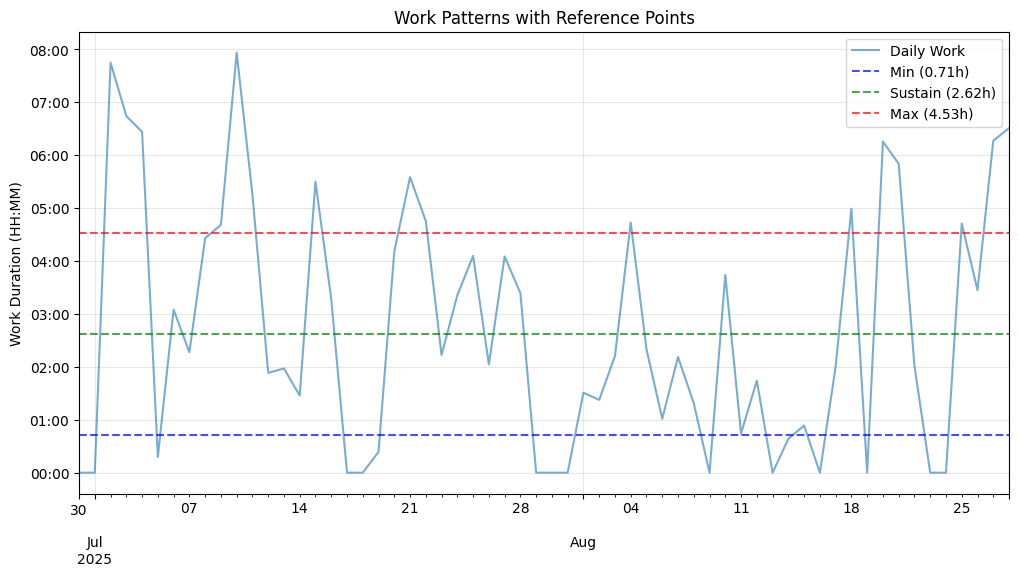

In [225]:
plot_reference_points(historical_df, 60)

/var/folders/sm/_zch1p6n05q67_3dyldhm3l40000gn/T/ipykernel_36367/273985539.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_heat = extended_heat[-1] if not extended_heat.empty else 0.0


(<Figure size 1500x800 with 2 Axes>,
 array([<Axes: title={'center': 'Raw Totals and Smoothed Intensity'}>,
        <Axes: title={'center': 'System Heat (relative to recent work patterns)'}>],
       dtype=object))

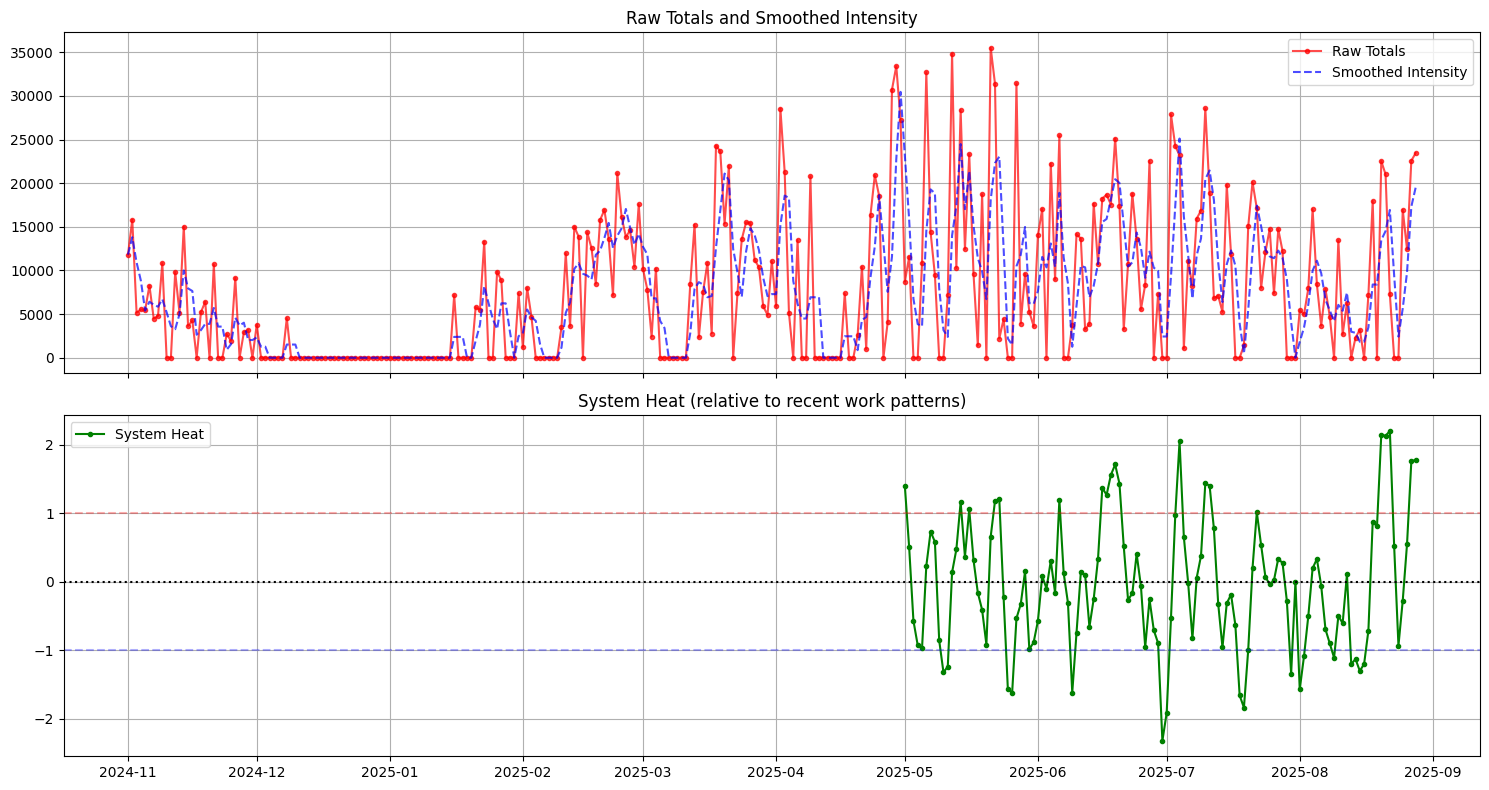

In [226]:
visualize_heat(historical_df, today_df, 16, 120)

/var/folders/sm/_zch1p6n05q67_3dyldhm3l40000gn/T/ipykernel_36367/2562876031.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_heat = extended_heat[-1]


(<Figure size 1500x800 with 2 Axes>,
 array([<Axes: title={'center': 'Raw Totals and Smoothed Intensity'}, ylabel='Duration (hh:mm)'>,
        <Axes: title={'center': 'System Heat (relative to recent work patterns)'}>],
       dtype=object))

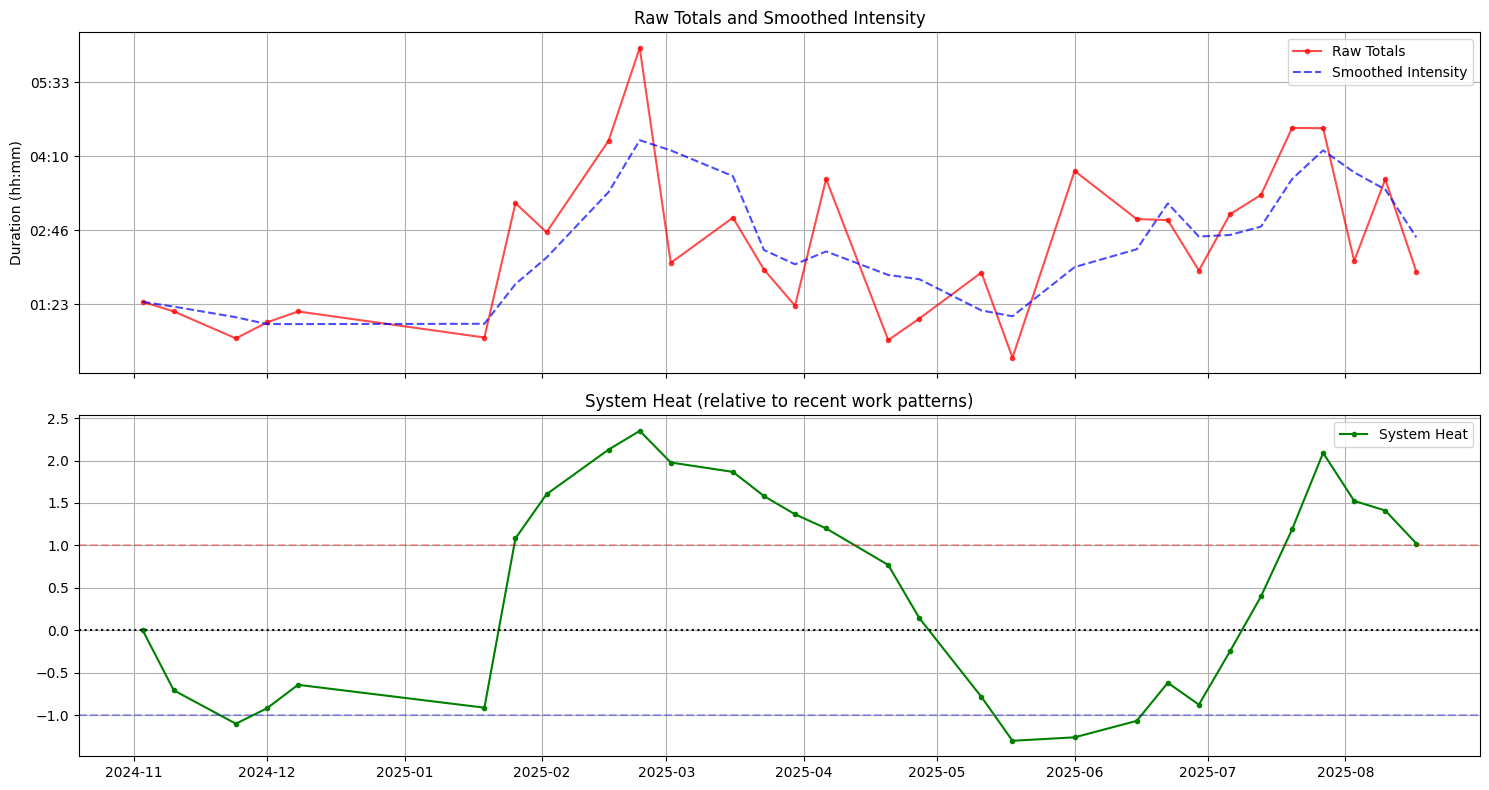

In [227]:
visualize_weekday_heat(historical_df, today_df, 8, 120, 6)

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Total Work Duration by Weekday (Sydney Time)'}, xlabel='Date (Sydney Time)', ylabel='Duration (hh:mm)'>)

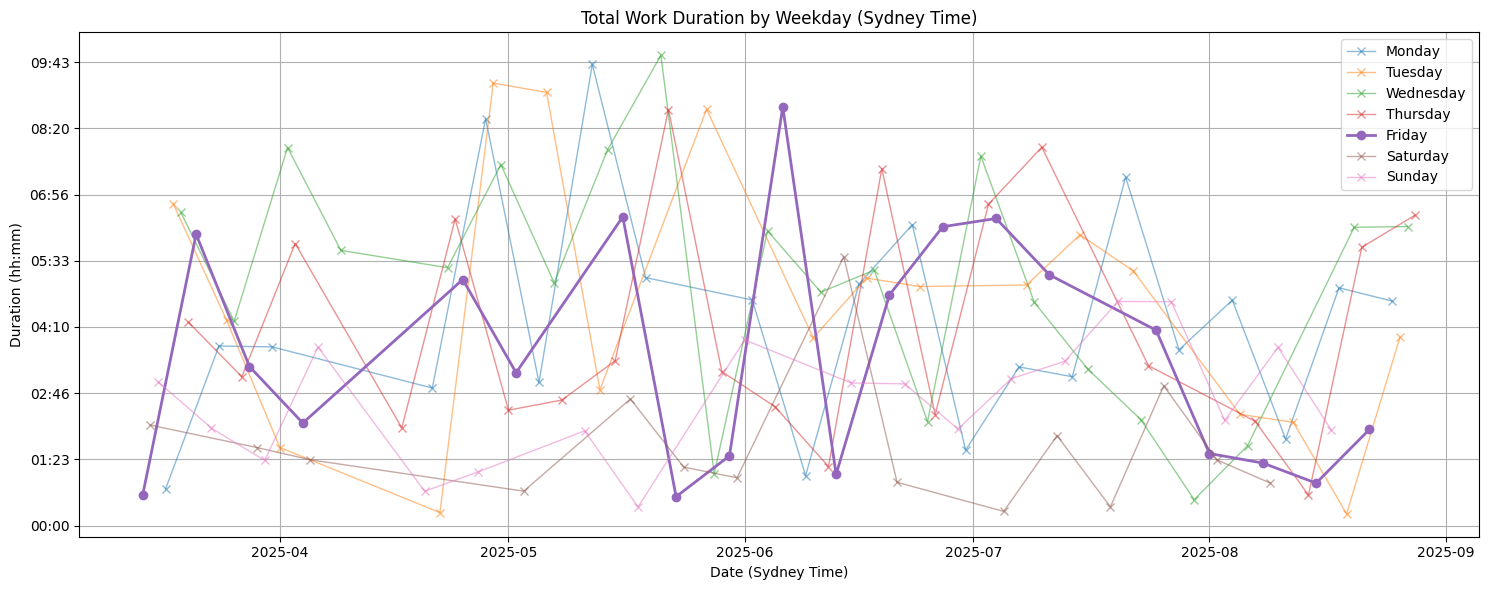

In [228]:
plot_all_weekdays_total_work(historical_df, today_df, 24)


# Write Oracle data to Supabase

In [229]:
# --- Write oracle data to sb for reading from scriptable side

def write_oracle_summary_to_supabase(measures, supabase_manager):
    """
    Write Oracle View summary data to Supabase using Measures and SupabaseManager.

    Args:
        measures (Measures): Instance of Measures class with oracle signals
        supabase_manager (SupabaseManager): Instance of SupabaseManager for writing
        date (datetime.date): Date of the summary (default: today)
    """
    summary = oracle_metrics
    response = supabase_manager._sb_write(summary, 'oracle_metrics_v2', on_conflict='date')
    return response

# write_oracle_summary_to_supabase(m2, sm)
write_oracle_summary_to_supabase(oracle_metrics, sm)


2025-08-29 07:54:42,835:INFO - Writing data to oracle_metrics_v2
2025-08-29 07:54:43,560:INFO - HTTP Request: POST https://wbrsvphudomszybcppoi.supabase.co/rest/v1/oracle_metrics_v2?on_conflict=date "HTTP/1.1 201 Created"
2025-08-29 07:54:43,599:INFO - Successfully pushed data to oracle_metrics_v2


APIResponse[~_ReturnT](data=[{'date': '2025-08-29', 'hot_tag': 'coding', 'hot_emoji': '👾', 'hot_qty': 201, 'hot_progress': 0, 'middle_tag': None, 'middle_emoji': None, 'middle_qty': None, 'middle_progress': 0, 'neglected_tag': None, 'neglected_emoji': None, 'neglected_qty': None, 'neglected_progress': 0, 'historical_heat': [1.77809450053971, 1.75493083000709, 0.549923563119048, -0.27461905220115, -0.933177242329219, 0.516306554688091, 2.19961417239632, 2.12680049994285, 2.14456152180337, 0.806684489617627, 0.874592098301547, -0.712276712205253, -1.19906243669234], 'today_heat': 0.96749776103229, 'min_ref': 0.73, 'sustain_ref': 1.83, 'max_ref': 3.15, 'weekday_totals': [7741.0, 12009.0, 22002.0, 2343.0, 17565.0, 14870.0, 15406.0, 7383.0, 1965.0, 1920.0, 1857.0, 4272.0, 2289.0, 3631.0, 6928.0, 11815.0]}], count=None)